In [1]:
import cv2
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
## 单个图像的聚类分析

In [3]:
def ClusterImage(img_path,k):
    img = cv2.imread(img_path)
    rgb_image = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    pixels = rgb_image.reshape((-1,3))
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(pixels)
    colors = kmeans.cluster_centers_.astype(int)
    return colors

In [4]:
colors = ClusterImage(img_path = '5185d53bfdc9f03fd5001493.jpg',k = 5)
colors

array([[ 37,  42,  27],
       [184, 188, 192],
       [ 75,  78,  49],
       [109, 118,  68],
       [159, 156, 156]])

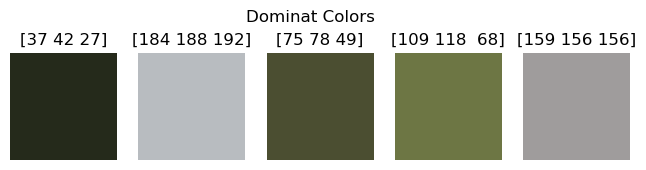

In [5]:
plt.figure(figsize = (8,2))
for i,color in enumerate(colors):
    plt.subplot(1,5,i+1)
    plt.imshow(np.ones((50,50,3),dtype = 'uint8')*color)
    plt.title(f'{color}')
    plt.axis('off')
plt.suptitle('Dominat Colors')
plt.show()

In [6]:
# 批量处理图片

In [7]:
from pathlib import Path
folder_path = Path('/Users/zhaojunran/Documents/Python_Urban_Perception_and_Visual_Character/MIT_Place_Pulse_archive/gsv/final_photo_dataset')
jpg_files = []
for f in folder_path.iterdir():
    if f.is_file() and f.suffix.lower() == '.jpg':
        jpg_files.append(f)

In [8]:
len(jpg_files)

110688

In [9]:
jpg_files

[PosixPath('/Users/zhaojunran/Documents/Python_Urban_Perception_and_Visual_Character/MIT_Place_Pulse_archive/gsv/final_photo_dataset/51415142fdc9f04926007f43.jpg'),
 PosixPath('/Users/zhaojunran/Documents/Python_Urban_Perception_and_Visual_Character/MIT_Place_Pulse_archive/gsv/final_photo_dataset/50f5ed9afdc9f065f0008e32.jpg'),
 PosixPath('/Users/zhaojunran/Documents/Python_Urban_Perception_and_Visual_Character/MIT_Place_Pulse_archive/gsv/final_photo_dataset/513e6050fdc9f0358700b395.jpg'),
 PosixPath('/Users/zhaojunran/Documents/Python_Urban_Perception_and_Visual_Character/MIT_Place_Pulse_archive/gsv/final_photo_dataset/50f5eb28fdc9f065f0008096.jpg'),
 PosixPath('/Users/zhaojunran/Documents/Python_Urban_Perception_and_Visual_Character/MIT_Place_Pulse_archive/gsv/final_photo_dataset/50f5ec32fdc9f065f00087a7.jpg'),
 PosixPath('/Users/zhaojunran/Documents/Python_Urban_Perception_and_Visual_Character/MIT_Place_Pulse_archive/gsv/final_photo_dataset/513e200cfdc9f0358700a0ce.jpg'),
 PosixPath

In [10]:
# 定义函数

In [19]:
# 1.批量的聚类分析函数
def ClusterImage_Updated(img_path,k):
    img = cv2.imread(img_path)
    rgb_image = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    pixels = rgb_image.reshape((-1,3))
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(pixels)
    colors = kmeans.cluster_centers_.astype(int)
    # 计算各颜色比
    labels,counts = np.unique(kmeans.labels_,return_counts = True)
    # kmeans.labels_ ： 这是 KMeans 聚类模型中，每个样本（图像中的一个像素）对应的聚类标签。
    # 使用 np.unique 函数统计每个聚类标签的出现次数，labels 存储唯一的聚类标签，counts 存储每个标签的出现次数
    total = counts.sum()
    ratios = counts / total
    return colors,ratios # 返回每个簇中心的颜色及其比例

# 2.统一颜色结构 : 建立标准色列表 -> 将颜色转化为HSV格式 ->在 HSV 色彩空间 中匹配

# 2.1.标准色列表
standard_colors = {
    'red':[255,0,0],
    'green':[0,255,0],
    'blue':[0,0,255],
    'yellow':[255,255,0],
    'cyan':[0,255,255],
    'magenta':[255,0,255],
    'gray':[128,128,128],
    'black':[0,0,0],
    'white':[255,255,255]
}

# 2.2.定义RGB转化为HSV的函数
def rgb_to_hsv_color(rgb_color):
    rgb_pixel = np.uint8([[rgb_color]])
    # np.uint8 是 NumPy 中的无符号 8 位整数类型。这行代码将输入的 rgb_color 转换为一个二维数组，并且数据类型为 np.uint8。
    # 之所以使用二维数组，是因为 cv2.cvtColor 函数要求输入的图像数据是一个二维或三维的数组。
    
    hsv_pixel = cv2.cvtColor(rgb_pixel,cv2.COLOR_RGB2HSV)
    # 将转化为二维数组的unit8 pixel从RGB转化为HSV
    
    return hsv_pixel[0][0]
    # 这行代码返回转换后的 HSV 颜色值。由于之前将输入转换为了二维数组，因此这里通过 hsv_pixel[0][0] 取出实际的 HSV 颜色值。
    # return hsv_pixel[0][0]：由于hsv_pixel是一个二维数组，hsv_pixel[0][0]用于提取数组中第一个元素的值，即转换后的HSV颜色值。

# 2.3.定义判断颜色名称的函数
# OpenCV 的 HSV 色相范围是 0-180（而非标准 HSV 的 0-360），因此数值需减半理解
def match_hsv_to_color(hsv_color):
    h,s,v = hsv_color

    # 区分灰阶颜色
    if s < 30:
        if v < 50:
            return 'black'
        elif v > 200:
            return 'white'
        else:
            return 'gray'

    # 色相区域判断(OpenCV hue范围为 0-180)
    if h < 10 or h >= 160:
        return "red"
    elif 10 <= h < 25:
        return "orange"
    elif 25 <= h < 35:
        return "yellow"
    elif 35 <= h < 85:
        return "green"
    elif 85 <= h < 125:
        return "cyan"
    elif 125 <= h < 145:
        return "blue"
    elif 145 <= h < 160:
        return "purple"
    else:
        return "other"

# 3.定义聚合数据的函数
from collections import OrderedDict
def merge_color_ratios(matched_colors,color_ratios):
    merged = OrderedDict()
    for label,ratio in zip(matched_colors,color_ratios):
        if label in merged:
            merged[label] += ratio
        else:
            merged[label] = ratio
    merged_labels = list(merged.keys())
    merged_ratios = list(merged.values())
    return merged_labels,merged_ratios

In [20]:
# 主色聚类的聚类分析+整合数据函数

In [21]:
def GetMainColor(img_path,k):
    image_data = {}
    hsvs = []
    labels = []

    # 分别聚类分析
    colors,ratios = ClusterImage_Updated(img_path = img_path,k = 5)

    # 统一颜色结构
    for color in colors:
        hsv = rgb_to_hsv_color(color)
        hsvs.append(hsv)
        label = match_hsv_to_color(hsv)
        labels.append(label)

    # 聚合分析
    matched_colors,matched_ratios = merge_color_ratios(labels,ratios)

    image_data = {
        'image_path' : img_path,
        'cluster_centers_rgb' : colors,
        'color_ratios_raw' : ratios,
        'cluster_centers_hsv' : hsvs,
        'matched_colors_raw' : labels,
        'matched_colors' : matched_colors,
        'color_ratios_matched' : matched_ratios
    }

    return image_data

In [22]:
image_data = GetMainColor(img_path = '/Users/zhaojunran/Documents/Python_Urban_Perception_and_Visual_Character/MIT_Place_Pulse_archive/gsv/final_photo_dataset/5185d53bfdc9f03fd5001493.jpg',k=5)

In [23]:
df = pd.DataFrame.from_dict(image_data,orient = 'index').reset_index().rename(columns = {'index':'image_path'})
# 这部分代码使用 pandas 库的 DataFrame.from_dict 方法将字典 image_data 转换为一个 DataFrame 对象。
# orient='index' 表示字典的键（key）将作为 DataFrame 的行索引，字典的值（value）将作为 DataFrame 的列
# .RESET_INDEX()这一步操作会重置 DataFrame 的索引。原本作为行索引的字典键会被转换为 DataFrame 的一列，同时生成一个新的整数索引。
df

,image_path,0
0,image_path,/Users/zhaojunran/Documents/Python_Urban_Perce...
1,cluster_centers_rgb,"[[160, 156, 156], [75, 78, 49], [109, 117, 68]..."
2,color_ratios_raw,"[0.13681666666666667, 0.16358333333333333, 0.1..."
3,cluster_centers_hsv,"[[0, 6, 160], [33, 95, 78], [35, 107, 117], [3..."
4,matched_colors_raw,"[gray, yellow, green, green, gray]"
5,matched_colors,"[gray, yellow, green]"
6,color_ratios_matched,"[0.44810833333333333, 0.16358333333333333, 0.3..."


In [24]:
### 主色聚类

In [17]:
jpg_files

[PosixPath('/Users/zhaojunran/Documents/Python_Urban_Perception_and_Visual_Character/MIT_Place_Pulse_archive/gsv/final_photo_dataset/51415142fdc9f04926007f43.jpg'),
 PosixPath('/Users/zhaojunran/Documents/Python_Urban_Perception_and_Visual_Character/MIT_Place_Pulse_archive/gsv/final_photo_dataset/50f5ed9afdc9f065f0008e32.jpg'),
 PosixPath('/Users/zhaojunran/Documents/Python_Urban_Perception_and_Visual_Character/MIT_Place_Pulse_archive/gsv/final_photo_dataset/513e6050fdc9f0358700b395.jpg'),
 PosixPath('/Users/zhaojunran/Documents/Python_Urban_Perception_and_Visual_Character/MIT_Place_Pulse_archive/gsv/final_photo_dataset/50f5eb28fdc9f065f0008096.jpg'),
 PosixPath('/Users/zhaojunran/Documents/Python_Urban_Perception_and_Visual_Character/MIT_Place_Pulse_archive/gsv/final_photo_dataset/50f5ec32fdc9f065f00087a7.jpg'),
 PosixPath('/Users/zhaojunran/Documents/Python_Urban_Perception_and_Visual_Character/MIT_Place_Pulse_archive/gsv/final_photo_dataset/513e200cfdc9f0358700a0ce.jpg'),
 PosixPath

In [29]:
images_data = []
folder_path = '/Users/zhaojunran/Documents/Python_Urban_Perception_and_Visual_Character/MIT_Place_Pulse_archive/gsv/final_photo_dataset'
for img in jpg_files:
    img_path = f'{img}'

    #     image_data = {
    #     'image_path' : img_path,
    #     'cluster_centers_rgb' : colors,
    #     'color_ratios_raw' : ratios,
    #     'cluster_centers_hsv' : hsvs,
    #     'matched_colors_raw' : labels,
    #     'matched_colors' : matched_colors,
    #     'color_ratios_matched' : matched_ratios
    # }
    
    try:
        image_data = GetMainColor(img_path = str(img_path),k=5)
        image_data['file_name'] = img # 添加file_name:img到image_data字典
        images_data.append(image_data)

    except Exception as e:
        print(f'Failed to process {img}:{e}')
        continue # 跳过当前图片,下一个

img_df = pd.DataFrame(images_data)

In [31]:
img_df.to_csv('20251027_imgs_data.csv')

In [32]:
# 定义计算hsv数据的函数
def extract_hsv_statistics(image_path):
    img_bgr = cv2.imread(image_path) # cv2.imread读取的都是bgr
    if img_bgr is None:
        raise ValueError(f"无法读取图像：{image_path}")
        # raise 关键字用于抛出异常，这里抛出的是 ValueError 异常，它表示传入的参数不符合要求。
    img_hsv = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(img_hsv) # 这里split是因为是对图像的颜色进行分离,上面的可以直接分离因为是np数组
    stats = {
        'h_mean':np.mean(h),
        'h_max':np.max(h),
        's_mean':np.mean(s),
        's_std':np.std(s),# std计算标准差
        's_max':np.max(s),
        'v_mean':np.mean(v),
        'v_std':np.std(v),
        'v_max':np.max(v)
    }
    return stats

In [34]:
# 批量计算hsv数据
images_hsv_data = []
folder_path = '/Users/zhaojunran/Documents/Python_Urban_Perception_and_Visual_Character/MIT_Place_Pulse_archive/gsv/final_photo_dataset'
# 这是批量读取图像的固定格式:
for img in jpg_files:
    img_path = f'{img}'
    hsv_data = extract_hsv_statistics(image_path = str(img_path))
    hsv_data['filename'] = img
    images_hsv_data.append(hsv_data)

In [35]:
hsv_df = pd.DataFrame(images_hsv_data)

In [36]:
hsv_df.head()

,h_mean,h_max,s_mean,s_std,s_max,v_mean,v_std,v_max,filename
0,59.777342,179,43.972458,47.028663,255,146.078017,38.866027,255,/Users/zhaojunran/Documents/Python_Urban_Perce...
1,44.728267,177,62.034242,41.408582,255,94.703683,51.186055,255,/Users/zhaojunran/Documents/Python_Urban_Perce...
2,52.645892,179,70.778517,58.379556,255,143.088600,57.338692,255,/Users/zhaojunran/Documents/Python_Urban_Perce...
3,59.708800,179,29.269000,40.494037,255,136.006450,59.505852,255,/Users/zhaojunran/Documents/Python_Urban_Perce...
4,46.192183,179,49.982708,49.659904,255,126.712392,48.076530,255,/Users/zhaojunran/Documents/Python_Urban_Perce...


In [37]:
img_df.head()

,image_path,cluster_centers_rgb,color_ratios_raw,cluster_centers_hsv,matched_colors_raw,matched_colors,color_ratios_matched,file_name
0,/Users/zhaojunran/Documents/Python_Urban_Perce...,"[[153, 159, 165], [22, 80, 129], [73, 70, 53],...","[0.3373583333333333, 0.03793333333333333, 0.13...","[[105, 19, 165], [104, 212, 129], [26, 70, 73]...","[gray, cyan, yellow, orange, gray]","[gray, cyan, yellow, orange]","[0.49871666666666664, 0.03793333333333333, 0.1...",/Users/zhaojunran/Documents/Python_Urban_Perce...
1,/Users/zhaojunran/Documents/Python_Urban_Perce...,"[[36, 34, 26], [134, 125, 115], [171, 174, 177...","[0.2744083333333333, 0.14163333333333333, 0.17...","[[24, 71, 36], [16, 36, 134], [105, 9, 177], [...","[orange, orange, gray, yellow, yellow]","[orange, gray, yellow]","[0.41604166666666664, 0.17175833333333335, 0.4...",/Users/zhaojunran/Documents/Python_Urban_Perce...
2,/Users/zhaojunran/Documents/Python_Urban_Perce...,"[[152, 147, 119], [52, 53, 32], [214, 215, 209...","[0.20368333333333333, 0.197425, 0.140275, 0.20...","[[25, 55, 152], [31, 101, 53], [35, 7, 215], [...","[yellow, yellow, white, yellow, cyan]","[yellow, white, cyan]","[0.6081083333333333, 0.140275, 0.2516166666666...",/Users/zhaojunran/Documents/Python_Urban_Perce...
3,/Users/zhaojunran/Documents/Python_Urban_Perce...,"[[40, 41, 34], [205, 206, 205], [147, 149, 147...","[0.15136666666666668, 0.252225, 0.206816666666...","[[34, 44, 41], [60, 1, 206], [60, 3, 149], [45...","[yellow, white, gray, gray, gray]","[yellow, white, gray]","[0.15136666666666668, 0.252225, 0.596408333333...",/Users/zhaojunran/Documents/Python_Urban_Perce...
4,/Users/zhaojunran/Documents/Python_Urban_Perce...,"[[150, 149, 145], [40, 43, 24], [121, 117, 111...","[0.224075, 0.14945833333333333, 0.334358333333...","[[24, 8, 150], [35, 113, 43], [18, 21, 121], [...","[gray, green, gray, gray, yellow]","[gray, green, yellow]","[0.713775, 0.14945833333333333, 0.136766666666...",/Users/zhaojunran/Documents/Python_Urban_Perce...


In [40]:
img_df = img_df.drop(columns = ['image_path'])

In [44]:
img_df = img_df.rename(columns = {'file_name':'filename'})

In [45]:
merged = img_df.merge(hsv_df,on='filename')
merged = merged.reset_index()
merged.head()

,index,cluster_centers_rgb,color_ratios_raw,cluster_centers_hsv,matched_colors_raw,matched_colors,color_ratios_matched,filename,h_mean,h_max,s_mean,s_std,s_max,v_mean,v_std,v_max
0,0,"[[153, 159, 165], [22, 80, 129], [73, 70, 53],...","[0.3373583333333333, 0.03793333333333333, 0.13...","[[105, 19, 165], [104, 212, 129], [26, 70, 73]...","[gray, cyan, yellow, orange, gray]","[gray, cyan, yellow, orange]","[0.49871666666666664, 0.03793333333333333, 0.1...",/Users/zhaojunran/Documents/Python_Urban_Perce...,59.777342,179,43.972458,47.028663,255,146.078017,38.866027,255
1,1,"[[36, 34, 26], [134, 125, 115], [171, 174, 177...","[0.2744083333333333, 0.14163333333333333, 0.17...","[[24, 71, 36], [16, 36, 134], [105, 9, 177], [...","[orange, orange, gray, yellow, yellow]","[orange, gray, yellow]","[0.41604166666666664, 0.17175833333333335, 0.4...",/Users/zhaojunran/Documents/Python_Urban_Perce...,44.728267,177,62.034242,41.408582,255,94.703683,51.186055,255
2,2,"[[152, 147, 119], [52, 53, 32], [214, 215, 209...","[0.20368333333333333, 0.197425, 0.140275, 0.20...","[[25, 55, 152], [31, 101, 53], [35, 7, 215], [...","[yellow, yellow, white, yellow, cyan]","[yellow, white, cyan]","[0.6081083333333333, 0.140275, 0.2516166666666...",/Users/zhaojunran/Documents/Python_Urban_Perce...,52.645892,179,70.778517,58.379556,255,143.088600,57.338692,255
3,3,"[[40, 41, 34], [205, 206, 205], [147, 149, 147...","[0.15136666666666668, 0.252225, 0.206816666666...","[[34, 44, 41], [60, 1, 206], [60, 3, 149], [45...","[yellow, white, gray, gray, gray]","[yellow, white, gray]","[0.15136666666666668, 0.252225, 0.596408333333...",/Users/zhaojunran/Documents/Python_Urban_Perce...,59.708800,179,29.269000,40.494037,255,136.006450,59.505852,255
4,4,"[[150, 149, 145], [40, 43, 24], [121, 117, 111...","[0.224075, 0.14945833333333333, 0.334358333333...","[[24, 8, 150], [35, 113, 43], [18, 21, 121], [...","[gray, green, gray, gray, yellow]","[gray, green, yellow]","[0.713775, 0.14945833333333333, 0.136766666666...",/Users/zhaojunran/Documents/Python_Urban_Perce...,46.192183,179,49.982708,49.659904,255,126.712392,48.076530,255


In [46]:
merged.to_csv('20251027_imgs_hsv_data.csv')